# DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.776214582593902 -2.9865507933148012
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [11]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [12]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [13]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [15]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [16]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [17]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [18]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data
        self.rates = deque(maxlen=max_size) # rate

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [41]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 24*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e6)            # memory capacity
# batch_size = 64                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [42]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [43]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

In [44]:
num_step

15

In [45]:
batch = memory.buffer
# states = np.array([each[0] for each in batch])
# actions = np.array([each[1] for each in batch])
# next_states = np.array([each[2] for each in batch])
# rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])

In [46]:
dones, np.argmax(dones), dones[np.argmax(dones)], dones[0]

(array([0., 0., 0., ..., 0., 0., 0.]), 27, 1.0, 0.0)

In [55]:
rates = np.array(memory.rates)

In [56]:
rates

array([ 0.056,  0.056,  0.056, ..., -1.   , -1.   , -1.   ])

In [57]:
np.max(rates), np.min(rates)

(0.298, -1.0)

In [58]:
num_step

15

In [59]:
rates[rates == np.max(rates)]

array([0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298, 0.298,
       0.298, 0.298,

In [67]:
batch = memory.buffer
percentage = 0.8
states = np.array([each[0] for each in batch])[rates >= (np.max(rates)*percentage)]
actions = np.array([each[1] for each in batch])[rates >= (np.max(rates)*percentage)]
next_states = np.array([each[2] for each in batch])[rates >= (np.max(rates)*percentage)]
rewards = np.array([each[3] for each in batch])[rates >= (np.max(rates)*percentage)]
dones = np.array([each[4] for each in batch])[rates >= (np.max(rates)*percentage)]
maxrates = np.array(memory.rates)[rates >= (np.max(rates)*percentage)]

In [68]:
# batch = memory.buffer
# states = np.array([each[0] for each in batch])[allrates >= 0]
# actions = np.array([each[1] for each in batch])[allrates >= 0]
# next_states = np.array([each[2] for each in batch])[allrates >= 0]
# rewards = np.array([each[3] for each in batch])[allrates >= 0]
# dones = np.array([each[4] for each in batch])[allrates >= 0]
# rates = np.array(memory.rates)[allrates >= 0]

In [69]:
states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, maxrates.shape

((766, 4), (766,), (766, 4), (766,), (766,), (766,))

In [70]:
num_step

15

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0 # each episode
        #gloss_batch, dloss_batch= [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            #gloss_batch.append(gloss)
            #dloss_batch.append(dlossA)
            if done is True:
                break
                
        # Rating the memory
        #if done is True:
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                memory.rates[-1-idx] = rate # rate the trajectory/data

        # Training maxrated batch
        batch = memory.buffer
        rates = np.array(memory.rates)
        percentage = 0.8
        states = np.array([each[0] for each in batch])[rates >= (np.max(rates)*percentage)]
        actions = np.array([each[1] for each in batch])[rates >= (np.max(rates)*percentage)]
        next_states = np.array([each[2] for each in batch])[rates >= (np.max(rates)*percentage)]
        rewards = np.array([each[3] for each in batch])[rates >= (np.max(rates)*percentage)]
        dones = np.array([each[4] for each in batch])[rates >= (np.max(rates)*percentage)]
        maxrates = np.array(memory.rates)[rates >= (np.max(rates)*percentage)]            
        nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
        #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
        nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
        targetQs = rewards + (gamma * nextQs)
        gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                   model.g_opt, model.d_optA, model.d_optQ],
                                                  feed_dict = {model.states: states, 
                                                               model.actions: actions,
                                                               model.targetQs: targetQs, 
                                                               model.rates: maxrates})
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:}'.format(total_reward),
              'rate:{}'.format(rate),
              'maxrate:{}'.format(np.max(maxrates)),
              'mbsize:{}'.format(len(maxrates)),
              'gloss:{:.4f}'.format(gloss),
              'dlossA:{:.4f}'.format(dlossA),
              'dlossQ:{:.4f}'.format(dlossQ),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:13.0000 R:13.0 rate:0.026 maxrate:0.298 mbsize:766 gloss:0.6169 dlossA:0.6680 dlossQ:1.9668 exploreP:0.9987
Episode:1 meanR:22.0000 R:31.0 rate:0.062 maxrate:0.298 mbsize:766 gloss:0.6165 dlossA:0.6680 dlossQ:1.9629 exploreP:0.9957
Episode:2 meanR:18.6667 R:12.0 rate:0.024 maxrate:0.298 mbsize:766 gloss:0.6161 dlossA:0.6680 dlossQ:1.9591 exploreP:0.9945
Episode:3 meanR:26.2500 R:49.0 rate:0.098 maxrate:0.298 mbsize:766 gloss:0.6156 dlossA:0.6679 dlossQ:1.9552 exploreP:0.9897
Episode:4 meanR:26.2000 R:26.0 rate:0.052 maxrate:0.298 mbsize:766 gloss:0.6152 dlossA:0.6679 dlossQ:1.9514 exploreP:0.9871
Episode:5 meanR:25.5000 R:22.0 rate:0.044 maxrate:0.298 mbsize:766 gloss:0.6148 dlossA:0.6678 dlossQ:1.9476 exploreP:0.9850
Episode:6 meanR:25.2857 R:24.0 rate:0.048 maxrate:0.298 mbsize:766 gloss:0.6144 dlossA:0.6678 dlossQ:1.9437 exploreP:0.9826
Episode:7 meanR:23.3750 R:10.0 rate:0.02 maxrate:0.298 mbsize:766 gloss:0.6140 dlossA:0.6678 dlossQ:1.9399 exploreP:0.9817
Episode:8

Episode:66 meanR:24.9851 R:43.0 rate:0.086 maxrate:0.298 mbsize:766 gloss:0.5902 dlossA:0.6647 dlossQ:1.7138 exploreP:0.8474
Episode:67 meanR:25.1471 R:36.0 rate:0.072 maxrate:0.298 mbsize:766 gloss:0.5898 dlossA:0.6647 dlossQ:1.7102 exploreP:0.8444
Episode:68 meanR:25.0435 R:18.0 rate:0.036 maxrate:0.298 mbsize:766 gloss:0.5894 dlossA:0.6647 dlossQ:1.7067 exploreP:0.8429
Episode:69 meanR:25.0857 R:28.0 rate:0.056 maxrate:0.298 mbsize:766 gloss:0.5890 dlossA:0.6646 dlossQ:1.7031 exploreP:0.8406
Episode:70 meanR:24.9155 R:13.0 rate:0.026 maxrate:0.298 mbsize:766 gloss:0.5886 dlossA:0.6645 dlossQ:1.6995 exploreP:0.8395
Episode:71 meanR:24.7917 R:16.0 rate:0.032 maxrate:0.298 mbsize:766 gloss:0.5883 dlossA:0.6645 dlossQ:1.6960 exploreP:0.8382
Episode:72 meanR:24.6575 R:15.0 rate:0.03 maxrate:0.298 mbsize:766 gloss:0.5879 dlossA:0.6644 dlossQ:1.6924 exploreP:0.8369
Episode:73 meanR:24.5811 R:19.0 rate:0.038 maxrate:0.298 mbsize:766 gloss:0.5875 dlossA:0.6643 dlossQ:1.6889 exploreP:0.8353
E

Episode:132 meanR:32.5300 R:19.0 rate:0.038 maxrate:0.298 mbsize:766 gloss:0.5638 dlossA:0.6602 dlossQ:1.5068 exploreP:0.6800
Episode:133 meanR:32.6000 R:17.0 rate:0.034 maxrate:0.298 mbsize:766 gloss:0.5634 dlossA:0.6602 dlossQ:1.5042 exploreP:0.6788
Episode:134 meanR:32.4900 R:11.0 rate:0.022 maxrate:0.298 mbsize:766 gloss:0.5630 dlossA:0.6601 dlossQ:1.5016 exploreP:0.6781
Episode:135 meanR:32.9200 R:61.0 rate:0.122 maxrate:0.298 mbsize:766 gloss:0.5626 dlossA:0.6600 dlossQ:1.4990 exploreP:0.6740
Episode:136 meanR:33.4300 R:84.0 rate:0.168 maxrate:0.298 mbsize:766 gloss:0.5621 dlossA:0.6599 dlossQ:1.4964 exploreP:0.6685
Episode:137 meanR:33.5800 R:89.0 rate:0.178 maxrate:0.298 mbsize:766 gloss:0.5617 dlossA:0.6599 dlossQ:1.4939 exploreP:0.6626
Episode:138 meanR:33.1900 R:18.0 rate:0.036 maxrate:0.298 mbsize:766 gloss:0.5613 dlossA:0.6598 dlossQ:1.4913 exploreP:0.6615
Episode:139 meanR:33.0700 R:9.0 rate:0.018 maxrate:0.298 mbsize:766 gloss:0.5609 dlossA:0.6597 dlossQ:1.4888 exploreP:

Episode:198 meanR:63.6200 R:142.0 rate:0.284 maxrate:0.32 mbsize:1427 gloss:0.5366 dlossA:0.6632 dlossQ:1.3806 exploreP:0.4133
Episode:199 meanR:64.6200 R:146.0 rate:0.292 maxrate:0.32 mbsize:1573 gloss:0.5381 dlossA:0.6642 dlossQ:1.3846 exploreP:0.4074
Episode:200 meanR:65.1700 R:99.0 rate:0.198 maxrate:0.32 mbsize:1573 gloss:0.5375 dlossA:0.6642 dlossQ:1.3819 exploreP:0.4035
Episode:201 meanR:65.5400 R:51.0 rate:0.102 maxrate:0.32 mbsize:1573 gloss:0.5368 dlossA:0.6641 dlossQ:1.3793 exploreP:0.4015
Episode:202 meanR:66.1900 R:98.0 rate:0.196 maxrate:0.32 mbsize:1573 gloss:0.5362 dlossA:0.6641 dlossQ:1.3766 exploreP:0.3977
Episode:203 meanR:67.0000 R:112.0 rate:0.224 maxrate:0.32 mbsize:1573 gloss:0.5355 dlossA:0.6639 dlossQ:1.3740 exploreP:0.3934
Episode:204 meanR:66.8800 R:38.0 rate:0.076 maxrate:0.32 mbsize:1573 gloss:0.5349 dlossA:0.6639 dlossQ:1.3714 exploreP:0.3919
Episode:205 meanR:67.7400 R:120.0 rate:0.24 maxrate:0.32 mbsize:1573 gloss:0.5342 dlossA:0.6639 dlossQ:1.3688 explo

Episode:263 meanR:98.5400 R:65.0 rate:0.13 maxrate:0.492 mbsize:1317 gloss:0.5117 dlossA:0.6886 dlossQ:1.2737 exploreP:0.2179
Episode:264 meanR:98.5700 R:117.0 rate:0.234 maxrate:0.492 mbsize:1317 gloss:0.5113 dlossA:0.6886 dlossQ:1.2706 exploreP:0.2155
Episode:265 meanR:99.1400 R:135.0 rate:0.27 maxrate:0.492 mbsize:1317 gloss:0.5108 dlossA:0.6886 dlossQ:1.2674 exploreP:0.2127
Episode:266 meanR:99.1900 R:88.0 rate:0.176 maxrate:0.492 mbsize:1317 gloss:0.5104 dlossA:0.6886 dlossQ:1.2643 exploreP:0.2110
Episode:267 meanR:99.2000 R:91.0 rate:0.182 maxrate:0.492 mbsize:1317 gloss:0.5100 dlossA:0.6886 dlossQ:1.2612 exploreP:0.2091
Episode:268 meanR:99.1600 R:131.0 rate:0.262 maxrate:0.492 mbsize:1317 gloss:0.5095 dlossA:0.6886 dlossQ:1.2581 exploreP:0.2065
Episode:269 meanR:99.8700 R:109.0 rate:0.218 maxrate:0.492 mbsize:1317 gloss:0.5091 dlossA:0.6887 dlossQ:1.2550 exploreP:0.2044
Episode:270 meanR:100.9500 R:135.0 rate:0.27 maxrate:0.492 mbsize:1317 gloss:0.5087 dlossA:0.6887 dlossQ:1.25

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

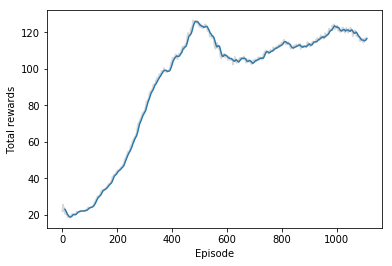

In [82]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

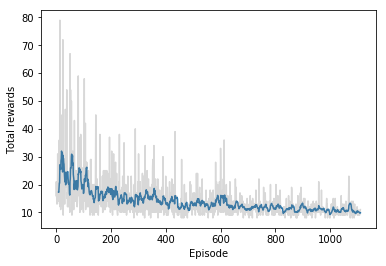

In [42]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

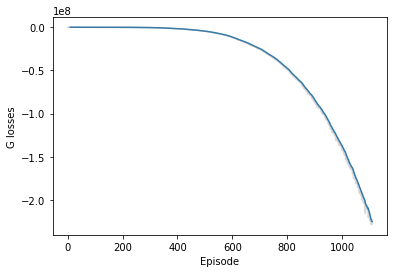

In [43]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

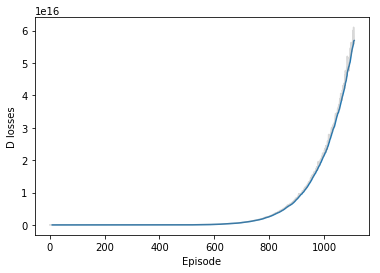

In [44]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.